# Xarray-spatial
### User Guide: Remote Sensing tools
-----

[Generate terrain](#Generate-Terrain-Data)
[Bump](#Bump)
[NDVI](#NDVI)

-----------


#### Let's use datashader to render our images...

In [1]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Generate Terrain Data

The rest of the geo-related functions focus on raster data (or rasterized data, after a previous Datashader step that returns an Xarray object). To demonstrate using these raster-based functions, let's generate some fake terrain as an elevation raster:

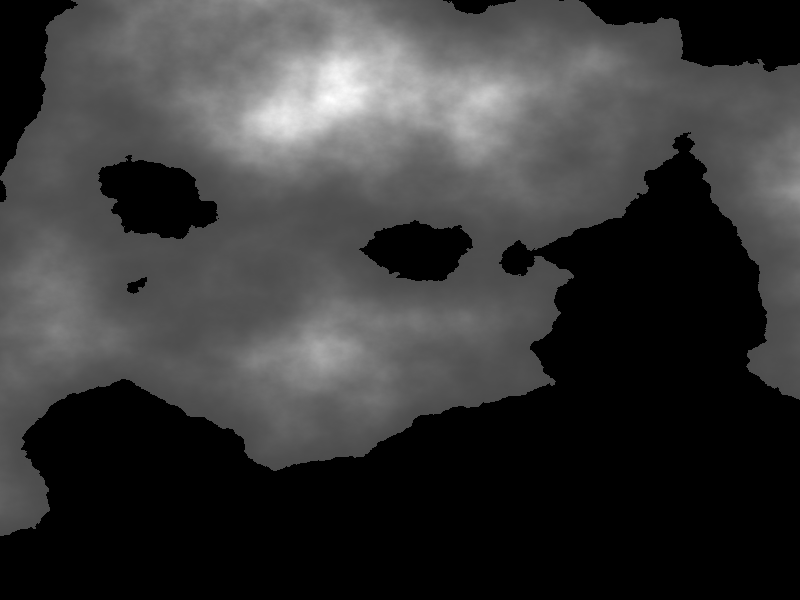

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20e6, 20e6), y_range=(-20e6, 20e6))
terrain = generate_terrain(canvas=cvs)

shade(terrain, cmap=['black', 'white'], how='linear')

The grayscale value above shows the elevation linearly in intensity (with the large black areas indicating low elevation), but it will look more like a landscape if we map the lowest values to colors representing water, and the highest to colors representing mountaintops:

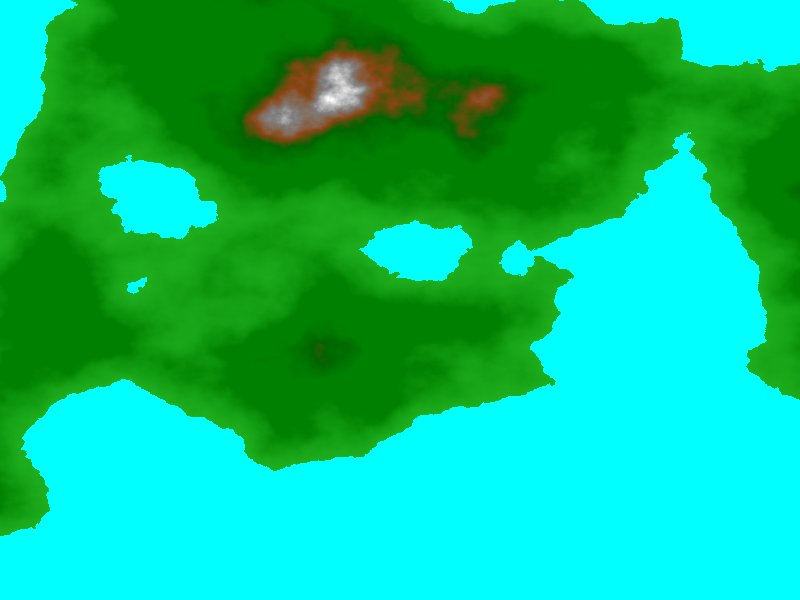

In [3]:
shade(terrain, cmap=Elevation, how='linear')

## NDVI

The [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) is a metric designed to detect regions with vegetation by measuring the difference between near-infrared (NIR) light (which vegetation reflects) and red light (which vegetation absorbs).

The NDVI ranges over [-1,+1], where `-1` means more "Red" radiation while `+1` means more "NIR" radiation. NDVI values close to +1.0 suggest areas dense with active green foliage, while strongly negative values suggest cloud cover or snow, and values near zero suggest open water, urban areas, or bare soil. 

For our synthetic example here, we don't have access to NIR measurements, but we can approximate the results for demonstration purposes by using the green and blue channels of a colormapped image, as those represent a difference in wavelength similar to NIR vs. Red.

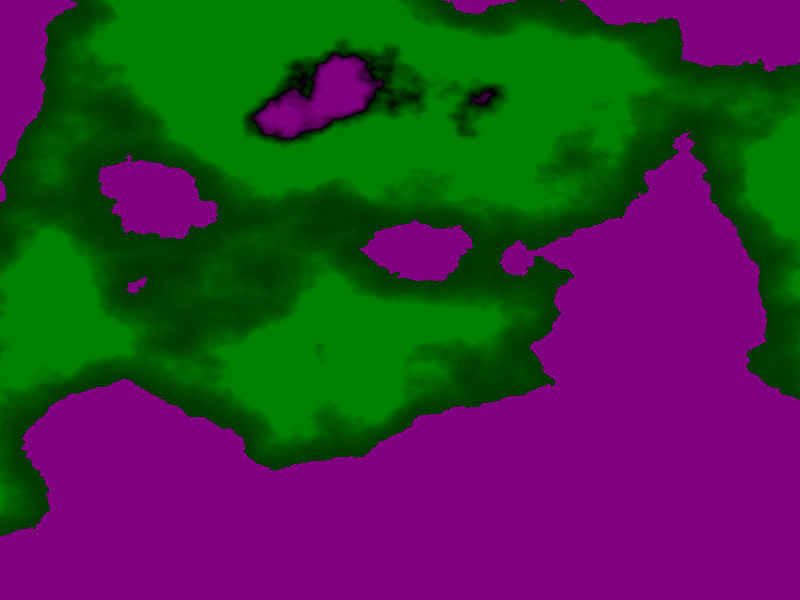

In [4]:
import xarray as xr

from xrspatial import ndvi

rgba = stack(shade(terrain, cmap=Elevation, how='linear')).to_pil()
r,g,b,a = [xr.DataArray(np.flipud(np.asarray(rgba.getchannel(c))))/255.0 
           for c in ['R','G','B','A']]

ndvi = ndvi(nir_agg=g, red_agg=b)
shade(ndvi, cmap=['purple','black','green'], how='linear')

## Bump

Bump mapping is a cartographic technique that can be used to create the appearance of trees or other land features, which is useful when synthesizing human-interpretable images from source data like land use classifications.

`dsgeo.bump` will produce a bump aggregate for adding detail to the terrain.

In this example, we will pretend the bumps are trees, and shade them with green.  We'll also use the elevation data to modulate whether there are trees and if so how tall they are.

- First, we'll define a custom `height` function to return tree heights suitable for the given elevation range
- `dsgeo.bump` accepts a function with only a single argument (`locations`), so we will use `functools.partial` to provide values for the other arguments.
- Bump mapping isn't normally a performance bottleneck, but if you want, you can speed it up by using Numba on your custom `height` function (`from xrspatial.utils import ngjit`, then put `@ngjit` above `def heights(...)`).

Wall time: 1.11 s


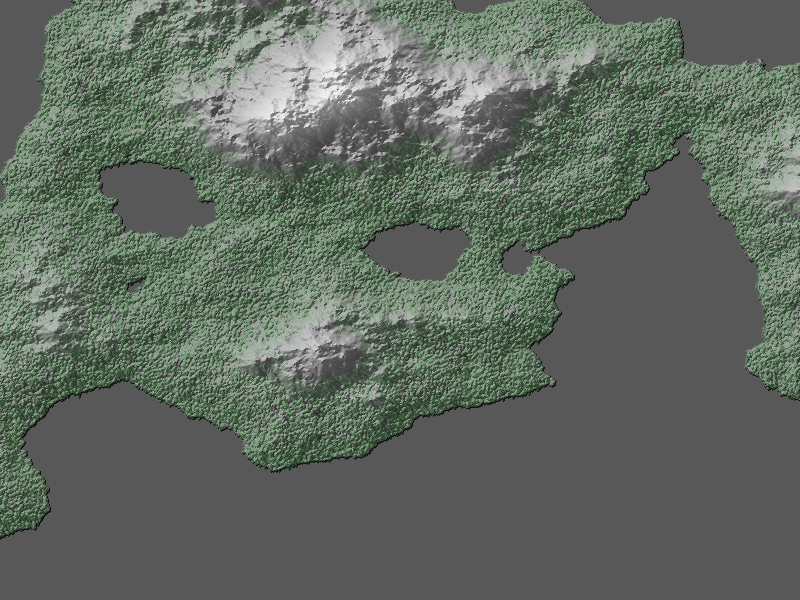

In [5]:
from functools import partial

from xrspatial import bump, hillshade

def heights(locations, src, src_range, height=20):
    num_bumps = locations.shape[0]
    out = np.zeros(num_bumps, dtype=np.uint16)
    for r in range(0, num_bumps):
        loc = locations[r]
        x = loc[0]
        y = loc[1]
        val = src[y, x]
        if val >= src_range[0] and val < src_range[1]:
            out[r] = height
    return out

T = 300000 # Number of trees to add per call
src = terrain.data
%time trees  = bump(W, H, count=T,    height_func=partial(heights, src=src, src_range=(1000, 1300), height=5))
trees       += bump(W, H, count=T//2, height_func=partial(heights, src=src, src_range=(1300, 1700), height=20))
trees       += bump(W, H, count=T//3, height_func=partial(heights, src=src, src_range=(1700, 2000), height=5))

tree_colorize = trees.copy()
tree_colorize.data[tree_colorize.data == 0] = np.nan
hillshaded = hillshade(terrain + trees)

stack(shade(terrain,        cmap=['black', 'white'], how='linear'),
      shade(hillshaded,      cmap=['black', 'white'], how='linear', alpha=128),
      shade(tree_colorize,  cmap='limegreen',        how='linear'))